In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

In [ ]:
import os
import shutil
import random
from tqdm import tqdm
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ultralytics import YOLO

In [ ]:
%matplotlib inline

Нужно объединить несколько датасетов в один и переименовать классы:
* 0 → hornet
* 1 → false_knight
* 2 → crystal


Размечен не полный объем собранного датасета. Крайние кадры:  
```

MAX_LABELED_FRAMES = {
    "hornet_YOLO": 2500,
    "false_knight_YOLO": 2270,
    "crystal_YOLO": 1120
}
```

Чтобы не было идеалогической учетки обучающий данных в валидацию, разделим сначала каждый класс по "времени" на тестовую и валидационную выборку, а потом уже перемешаем классы внутри выборки

In [ ]:

SOURCE_ROOT = "data_YOLO"
OUTPUT_ROOT = "yolo_dataset"
DEBUG_GT_DIR = os.path.join(OUTPUT_ROOT, "debug_gt")

VAL_SPLIT = 0.2
RANDOM_STATE = 42

ENEMY_CLASSES = {
    "hornet_YOLO": 0,
    "false_knight_YOLO": 1,
    "crystal_YOLO": 2
}

MAX_LABELED_FRAMES = {
    "hornet_YOLO": 2500,
    "false_knight_YOLO": 2270,
    "crystal_YOLO": 1120
}

IMG_EXTENSIONS = (".jpg", ".png")

In [ ]:
def draw_gt_and_save(img_path, label_path, save_path):
    img = cv2.imread(img_path)
    if img is None:
        return

    h, w, _ = img.shape

    with open(label_path, "r") as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())

            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                img,
                f"GT:{int(cls)}",
                (x1, max(20, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

    cv2.imwrite(save_path, img)


def prepare_dataset():
    random.seed(RANDOM_STATE)
    for split in ["train", "val"]:
        os.makedirs(os.path.join(OUTPUT_ROOT, "images", split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_ROOT, "labels", split), exist_ok=True)
    os.makedirs(DEBUG_GT_DIR, exist_ok=True)
    train_samples = []
    val_samples = []

    # разделение по времени

    for folder_name, class_id in ENEMY_CLASSES.items():
        dataset_path = os.path.join(SOURCE_ROOT, folder_name, "obj_train_data")

        if not os.path.isdir(dataset_path):
            raise RuntimeError(f"упс {dataset_path}")

        max_frames = MAX_LABELED_FRAMES[folder_name]

        images = sorted(
            f for f in os.listdir(dataset_path)
            if f.lower().endswith(IMG_EXTENSIONS)
        )[:max_frames]

        split_idx = int(len(images) * (1 - VAL_SPLIT))

        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        def collect(img_list, target):
            for img_name in img_list:
                img_path = os.path.join(dataset_path, img_name)
                label_path = os.path.join(
                    dataset_path, os.path.splitext(img_name)[0] + ".txt"
                )

                if not os.path.exists(label_path):
                    continue

                target.append({
                    "img": img_path,
                    "label": label_path,
                    "class_id": class_id
                })

        before_train = len(train_samples)
        before_val = len(val_samples)

        collect(train_imgs, train_samples)
        collect(val_imgs, val_samples)

        print(
        f"{folder_name}: "
        f"train={len(train_samples) - before_train}, "
        f"val={len(val_samples) - before_val}"
        )


    # перемешивание

    random.shuffle(train_samples)
    random.shuffle(val_samples)

    print(f"Train samples: {len(train_samples)}")
    print(f"Val samples:   {len(val_samples)}")

    # для визуальной оценки копирование 

    global_idx = 0

    for split, samples in [("train", train_samples), ("val", val_samples)]:
        for sample in tqdm(samples, desc=split):
            base_name = f"{split}_{global_idx:06d}"
            global_idx += 1

            out_img = os.path.join(OUTPUT_ROOT, "images", split, base_name + ".jpg")
            out_lbl = os.path.join(OUTPUT_ROOT, "labels", split, base_name + ".txt")

            shutil.copy(sample["img"], out_img)

            with open(sample["label"], "r") as f:
                lines = f.readlines()

            with open(out_lbl, "w") as f:
                for line in lines:
                    _, x, y, w, h = line.strip().split()
                    f.write(f"{sample['class_id']} {x} {y} {w} {h}\n")

            if global_idx <= 200:
                debug_path = os.path.join(DEBUG_GT_DIR, base_name + ".jpg")
                draw_gt_and_save(out_img, out_lbl, debug_path)

    # data.yaml для yolo
    yaml_path = os.path.join(OUTPUT_ROOT, "data.yaml")
    with open(yaml_path, "w") as f:
        f.write(f"""path: {os.path.abspath(OUTPUT_ROOT)}
train: images/train
val: images/val
names:
""")
        for name, idx in sorted(ENEMY_CLASSES.items(), key=lambda x: x[1]):
            f.write(f"  {idx}: {name.replace('_YOLO','')}\n")

    print("Завершен")
    print(f"data.yaml {yaml_path}")
    print(f"GT примеры для дебага {DEBUG_GT_DIR}/")




🔍 Сбор YOLO датасетов (temporal-safe split)...
  • hornet_YOLO: train=2000, val=500
  • false_knight_YOLO: train=3816, val=954
  • crystal_YOLO: train=4712, val=1178
✅ Train samples: 4712
✅ Val samples:   1178


val: 100%|██████████| 1178/1178 [00:12<00:00, 94.15it/s] 

🎉 Датасет готов без утечек
📄 data.yaml → yolo_dataset\data.yaml
🖼 GT примеры → yolo_dataset\debug_gt/


In [ ]:
prepare_dataset()

60+ FPS

Отлично для 2D-игр

Минимальная задержка

In [26]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="yolo_dataset/data.yaml",
    epochs=40,
    imgsz=640,
    batch=16,
    device=0,
    name="hollow_knight_detector"
)


New https://pypi.org/project/ultralytics/8.3.241 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=hollow_knight_detector2, nbs=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000179BA2D0A30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

In [47]:
MODEL_PATH = "runs/detect/hollow_knight_detector2/weights/best.pt"
DATASET_PATH = "yolo_dataset"

IMG_DIR = os.path.join(DATASET_PATH, "images", "val")
LABEL_DIR = os.path.join(DATASET_PATH, "labels", "val")

CLASS_NAMES = ['hornet', 'false_knight', 'crystal']
IOU_THRESHOLD = 0.5

model = YOLO(MODEL_PATH)
model.verbose = False


In [48]:
def compute_iou(boxA, boxB):
    # box = [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter
    return inter / union if union > 0 else 0


In [43]:
def load_yolo_labels(label_path, img_w, img_h):
    gt_boxes = []

    with open(label_path, "r") as f:
        for line in f:
            cls, xc, yc, w, h = map(float, line.strip().split())

            x1 = int((xc - w / 2) * img_w)
            y1 = int((yc - h / 2) * img_h)
            x2 = int((xc + w / 2) * img_w)
            y2 = int((yc + h / 2) * img_h)

            gt_boxes.append({
                "cls": int(cls),
                "bbox": [x1, y1, x2, y2]
            })

    return gt_boxes


In [ ]:
# def show_detection_examples(n_samples=5):
#     images = sorted(os.listdir(IMG_DIR))

#     assert len(images) > 0, "Пусто и грустно"

#     samples = np.random.choice(images, min(n_samples, len(images)), replace=False)

#     for img_name in samples:
#         img_path = os.path.join(IMG_DIR, img_name)
#         label_path = os.path.join(LABEL_DIR, img_name.replace(".jpg", ".txt"))

#         img = cv2.imread(img_path)
#         assert img is not None, f"Ошибка {img_path}"

#         h, w, _ = img.shape

#         gt_boxes = load_yolo_labels(label_path, w, h)
#         preds = model.predict(img, conf=0.3, verbose=False)[0]

#         vis = img.copy()

#         # GT
#         for gt in gt_boxes:
#             x1, y1, x2, y2 = gt["bbox"]
#             cls = CLASS_NAMES[gt["cls"]]
#             cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
#             cv2.putText(
#                 vis, f"GT: {cls}",
#                 (x1, max(20, y1 - 5)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6,
#                 (0, 255, 0), 2
#             )

#         # предсказания
#         for box in preds.boxes:
#             x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
#             cls = CLASS_NAMES[int(box.cls[0])]
#             conf = float(box.conf[0])

#             cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)
#             cv2.putText(
#                 vis, f"PRED: {cls} ({conf:.2f})",
#                 (x1, min(h - 5, y2 + 20)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6,
#                 (0, 0, 255), 2
#             )

#         # BGR → RGB !!!!
#         vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

#         plt.figure(figsize=(10, 6))
#         plt.imshow(vis_rgb)
#         plt.axis("off")
#         plt.title(img_name)
#         plt.tight_layout()
#         plt.show()


In [50]:
def show_detection_examples(n_samples=5):
    images = sorted(
        f for f in os.listdir(IMG_DIR)
        if f.lower().endswith((".jpg", ".png"))
    )

    assert len(images) > 0, "Пусто и грустно"

    samples = np.random.choice(images, min(n_samples, len(images)), replace=False)

    for img_name in samples:
        stem = os.path.splitext(img_name)[0]
        img_path = os.path.join(IMG_DIR, img_name)
        label_path = os.path.join(LABEL_DIR, stem + ".txt")

        if not os.path.exists(label_path):
            print(f"⚠️ Нет label для {img_name}")
            continue

        img = cv2.imread(img_path)
        assert img is not None, f"Ошибка чтения {img_path}"

        h, w, _ = img.shape

        gt_boxes = load_yolo_labels(label_path, w, h)
        preds = model.predict(img, conf=0.4, verbose=False)[0]

        vis = img.copy()

        # --- GT ---
        for gt in gt_boxes:
            x1, y1, x2, y2 = gt["bbox"]
            cls = CLASS_NAMES[gt["cls"]]
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                vis, f"GT: {cls}",
                (x1, max(20, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                (0, 255, 0), 2
            )

        # --- PRED ---
        if preds.boxes is not None:
            for box in preds.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                cls = CLASS_NAMES[int(box.cls[0])]
                conf = float(box.conf[0])

                cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(
                    vis, f"PRED: {cls} ({conf:.2f})",
                    (x1, min(h - 5, y2 + 20)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                    (0, 0, 255), 2
                )

        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.imshow(vis_rgb)
        plt.title(img_name)
        plt.axis("off")
        plt.tight_layout()
        plt.show()


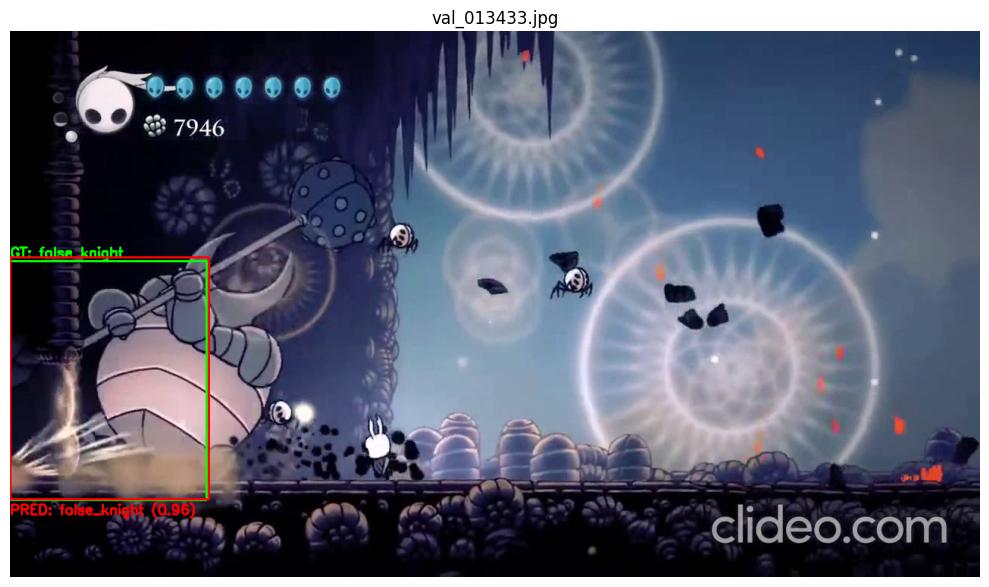

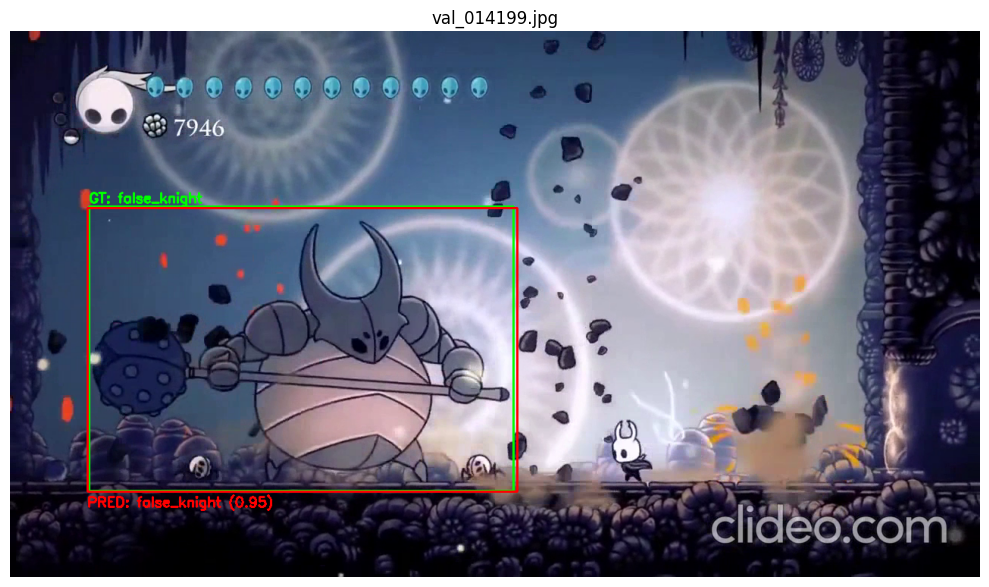

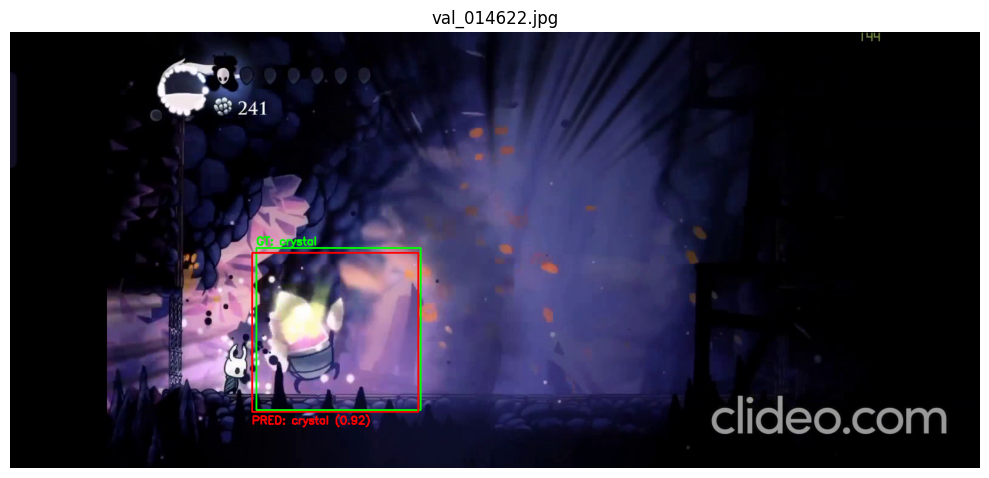

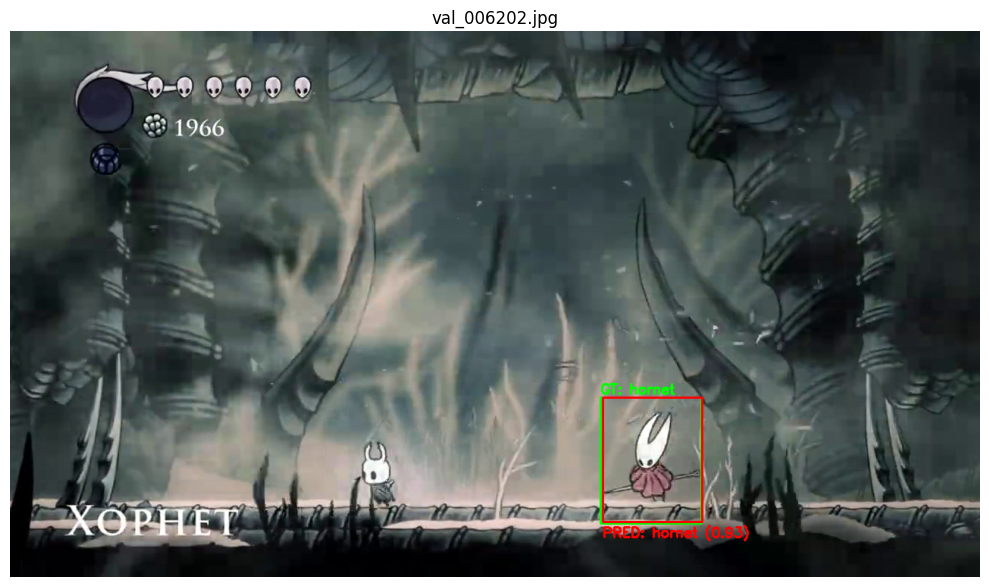

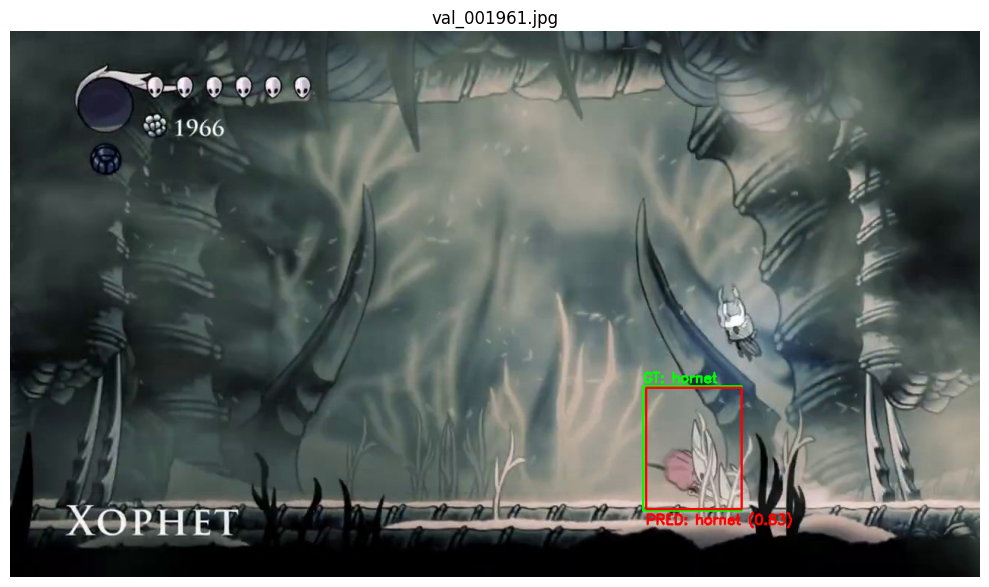

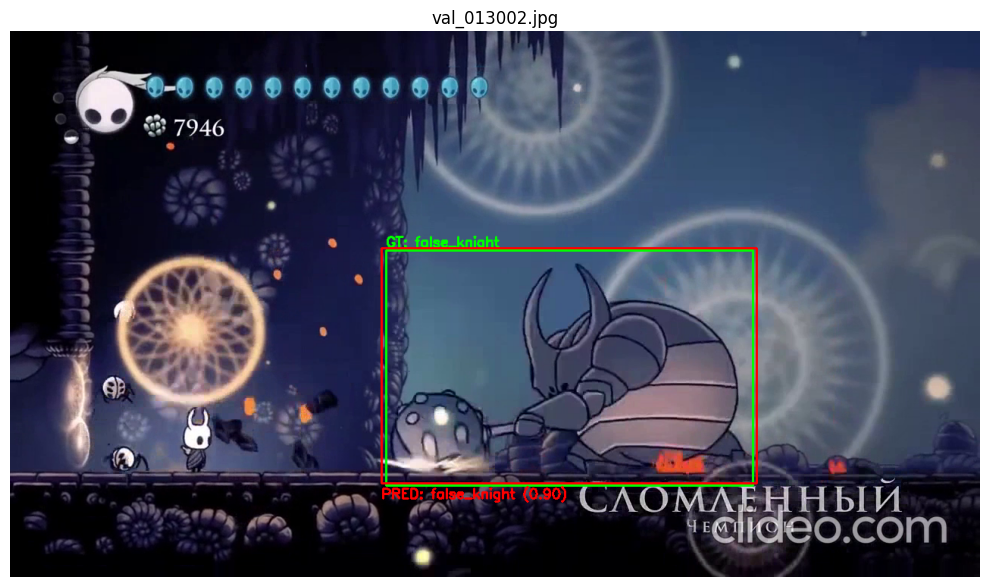

In [55]:
show_detection_examples(n_samples=6)



In [46]:
def evaluate_confusion_matrix():
    y_true = []
    y_pred = []

    images = sorted(os.listdir(IMG_DIR))

    for img_name in images:
        img_path = os.path.join(IMG_DIR, img_name)
        label_path = os.path.join(LABEL_DIR, img_name.replace(".jpg", ".txt"))

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        gt_boxes = load_yolo_labels(label_path, w, h)
        preds = model.predict(img, conf=0.3)[0].boxes

        matched_preds = set()

        for gt in gt_boxes:
            best_iou = 0
            best_pred = None

            for i, box in enumerate(preds):
                pred_bbox = box.xyxy[0].cpu().numpy()
                iou = compute_iou(gt["bbox"], pred_bbox)

                if iou > best_iou:
                    best_iou = iou
                    best_pred = (i, box)

            y_true.append(gt["cls"])

            if best_iou >= IOU_THRESHOLD and best_pred is not None:
                pred_cls = int(best_pred[1].cls[0])
                y_pred.append(pred_cls)
                matched_preds.add(best_pred[0])
            else:
                # FN → считаем как "не найден"
                y_pred.append(len(CLASS_NAMES))  # extra class

    labels = list(range(len(CLASS_NAMES))) + [len(CLASS_NAMES)]
    names = CLASS_NAMES + ["missed"]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    disp = ConfusionMatrixDisplay(cm, display_labels=names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Detection Confusion Matrix (IoU ≥ 0.5)")
    plt.show()


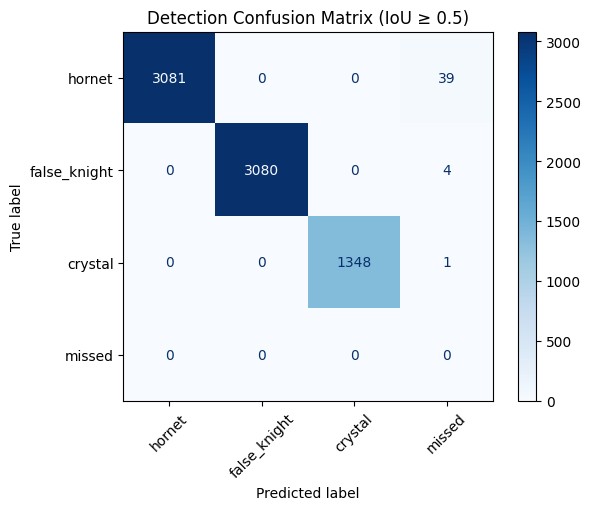

In [53]:
evaluate_confusion_matrix()
